Here:
- generate time series (cont OU process?)
- plot it (continious and also binned)
- calculate acf: using ABC tau, using py functions
- plot acf

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # comment this line if you don't want to use seaborn for plots

import numpy as np
# IP import warnings because of "module 'numpy' has no attribute 'warnings'"
import warnings
np.warnings = warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy import stats

# add the path to the abcTau package
import sys
#sys.path.append('./abcTau')
sys.path.append('C:\\Users\\ipochino\\.conda\\envs\\isttc\\Lib\\site-packages\\abcTau') # IP: replaced previous line with that; relative path was not working
import abcTau

# import from scripts
import os
os.chdir(os.path.expanduser("D:\\intr_timescales\\isttc\\scripts"))
# os.chdir(os.path.expanduser("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_acf import acf_sttc

In [3]:
def func_exp_abc_like(x, a, tau):
    return a * np.exp(-x/tau) 

### Generate time series

In [2]:
tau = np.array([100])
D = 1/tau
deltaT = 1
T = 100*1000
numTrials = 1

data_mean = 0.01 # average of firing rate
data_var = 0.02 # variance of firing rate

binSize = 50 # bins size for binning the data for calculating acf
binsData =  np.arange(0, T + binSize, binSize)
numBinData = len(binsData)-1
#print(binsData)
print(numBinData)

num_lags = 20
maxTimeLag = 1000 

2000


#### One tau OU

In [4]:
# OU process 
ou = abcTau.OU_gen(tau, D, deltaT, T, numTrials)
print('ou.shape: ', ou.shape)

ou_check = np.max(ou)
print(ou_check)
# adjust OU process - scale, shift 
ou_std = np.sqrt(data_var)
ou_mean = data_mean
ou_all = ou_std * ou + ou_mean # this is scale and shift, where is rectify? - no rectify here, this will come for the Poisson rate
print('ou_all.shape: ', ou_all.shape)

# bin for ACF calculation
ou_binned_data = abcTau.binData(ou_all, [numTrials, numBinData]) * deltaT
print(ou_binned_data.shape)

ou.shape:  (1, 100000)
3.2253378965472175
ou_all.shape:  (1, 100000)
(1, 2000)


#### One tau UO with Poisson spike count

In [5]:
ou_std =  np.sqrt(data_var - data_mean)/deltaT # law of total variance  
ou_mean = data_mean/deltaT # law of total expectation

# fit mean and var
ou_poisson = ou_std * ou + ou_mean
ou_poisson[ou_poisson < 0] = 0 # rectifying

# bin rate and generate spikes
numBin = int(T/deltaT)
ou_poisson_rate_ = abcTau.binData(ou_poisson, [numTrials,numBin]) * deltaT
ou_poisson_rate = np.random.poisson(ou_poisson_rate_)

# bin for ACF calculation
ou_poisson_binned = abcTau.binData(ou_poisson_rate, [numTrials, numBinData]) * deltaT
print(ou_poisson_binned.shape)

(1, 2000)


#### Going from rate to spikes

In [6]:
spikeTrain = np.zeros(ou_poisson_rate.shape)
print(spikeTrain.shape)

for i in range(ou_poisson_rate.shape[0]):
    spikeTrain[i,:] = [1 if ou_poisson_rate[i,j] > np.random.random() else 0 for j in range(ou_poisson_rate.shape[1])]

spike_times = np.where(np.squeeze(spikeTrain) == 1)[0]
print('N spikes {}'.format(spike_times.shape))

# bin for ACF calculation
ou_spiketrain_binned = abcTau.binData(spikeTrain, [numTrials, numBinData]) * deltaT
print(ou_spiketrain_binned.shape)

(1, 100000)
N spikes (4375,)
(1, 2000)


In [8]:
# store
# ou
np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\ou_all.npy', ou_all)
np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\ou_binned_data.npy', ou_binned_data)

# rates
np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\ou_poisson_rate.npy', ou_poisson_rate)
np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\ou_poisson_binned.npy', ou_poisson_binned)

# spikes
np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\spike_times.npy', spike_times)
np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\ou_spiketrain_binned.npy', ou_spiketrain_binned)

### Plot signals

In [ ]:
#ou = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_data\\ou_tau100ms_1trials_1000ms.npy')

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(20,15))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,ou.shape[1]-1,ou.shape[1]), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_xlabel('Time')
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,ou.shape[1]-1,ou.shape[1]), ou_all[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_xlabel('Time')
axes[1].set_title('One tau OU, scaled and shifted')

# that is supposed to be binned rate but it goes negative? is it ok?
axes[2].plot(np.linspace(0,numBinData-1,numBinData), ou_binned_data[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
axes[2].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[2].axvline(x=i, color='k', lw=0.5)
axes[2].set_xlabel('Time bins')
axes[2].set_title('One tau OU, scaled and shifted, binned')

sns.despine()

In [ ]:
fig, axes = plt.subplots(5,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,numBin-1,numBin), ou_poisson[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, scaled, shifted, rectified')

axes[2].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate_[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[2].axvline(x=50*i, color='k', lw=0.5)
axes[2].set_title('One tau OU, scaled, shifted, rectified - binned for getting spike count')

axes[3].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[3].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[3].axvline(x=50*i, color='k', lw=0.5)
axes[3].set_title('One tau OU, Poisson spike count')
# for i in range(numBinData+1):
#     axes[3].axvline(x=50*i, color='k', lw=0.5)

# that is supposed to be binned rate but it goes negative? is it ok?
axes[4].plot(np.linspace(0,numBinData-1,numBinData), ou_poisson_binned[0], lw=0.5)
axes[4].axhline(y=0, color='k', lw=0.5)
axes[4].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[4].axvline(x=i, color='k', lw=0.5)
axes[4].set_title('One tau OU, Poisson spike count binned')


for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(20,15))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU, Poisson spike count')

axes[1].plot(spike_times, np.ones_like(spike_times), '|', markersize=10, c='salmon')  # Plot spikes as a row,
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, Poisson spike train')

axes[2].plot(np.linspace(0,numBinData-1,numBinData), ou_spiketrain_binned[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
axes[2].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[2].axvline(x=i, color='k', lw=0.5)
axes[2].set_title('One tau OU, Poisson spike train, binned')

for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

### Calculate ACF and taus

In [9]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
ou_all_data_sumStat, ou_all_data_mean, ou_all_data_var, ou_all_T, ou_all_numTrials =  abcTau.preprocessing.extract_stats(ou_all, deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('ou_all_data_mean: {}, ou_all_data_var: {}, ou_all_T: {}, ou_all_numTrials: {}, \n ou_all_data_sumStat: {}'.format(ou_all_data_mean, 
                                                                                                                         ou_all_data_var, 
                                                                                                                         ou_all_T, 
                                                                                                                         ou_all_numTrials, 
                                                                                                                         ou_all_data_sumStat))
# Using acf func
ou_all_acf = acf(ou_binned_data[0], nlags=num_lags)
print('ou_all_acf: {}'.format(ou_all_acf))


# calculate tau

# Using abc but not bayesian
ou_all_abc_popt, ou_all_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(ou_all_data_sumStat, binSize, maxTimeLag)
print(ou_all_abc_popt)

# Using curve_fit
ou_all_popt, ou_all_pcov = curve_fit(func_exp_abc_like, np.linspace(0,20,21), ou_all_acf, maxfev=5000)
print(ou_all_popt)
ou_all_tau_ms = ou_all_popt[1] * binSize
print(ou_all_tau_ms)

ou_all_data_mean: 0.6661696585517741, ou_all_data_var: 41.60233039245058, ou_all_T: 100000, ou_all_numTrials: 1, 
 ou_all_data_sumStat: [ 1.          0.72878847  0.4542644   0.27470863  0.16383159  0.10099148
  0.04548425  0.00529255 -0.01622101 -0.02720201 -0.03512605 -0.04631822
 -0.04587097 -0.04037954 -0.03846921 -0.03187231 -0.00680938  0.04733408
  0.09278372  0.10846863]
ou_all_acf: [ 1.          0.72842434  0.45381071  0.27429718  0.16350461  0.1007397
  0.04534705  0.00527329 -0.01615898 -0.02708552 -0.034958   -0.04607041
 -0.0455994  -0.04011871 -0.03820092 -0.03163351 -0.00675454  0.04693175
  0.09194872  0.10743874  0.10867028]
[1. 1.]
[1.0428467  2.22920742]
111.46037122365844


C:\Users\ipochino\.conda\envs\isttc\Lib\site-packages\abcTau\preprocessing.py:451: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(single_exp, xdata, ydata, maxfev = 2000)


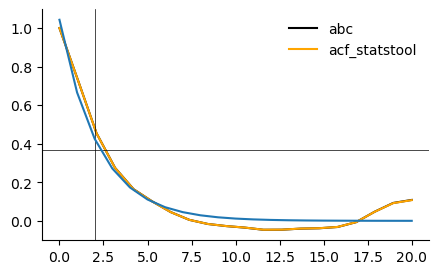

In [16]:
t_axis_lags = np.linspace(0, num_lags*binSize, num_lags)

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.plot(np.linspace(0,20,20), ou_all_data_sumStat, c='k', label='abc')
axes.plot(np.linspace(0,20,20), ou_all_acf[:-1], c='orange', label='acf_statstool')
axes.axvline(x=2, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')

axes.plot(np.linspace(0,20,21), func_exp_abc_like(np.linspace(0,20,21), ou_all_popt[0], ou_all_popt[1]))

axes.legend(frameon=False)

sns.despine()

In [11]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
ou_poisson_data_sumStat, ou_poisson_data_mean, ou_poisson_data_var, ou_poisson_T, ou_poisson_numTrials =  abcTau.preprocessing.extract_stats(ou_poisson_rate, 
                                                                                                                         deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('ou_poisson_data_mean: {}, ou_poisson_data_var: {}, ou_poisson_T: {}, ou_poisson_numTrials: {}, \n ou_poisson_data_sumStat: {}'.format(ou_poisson_data_mean, 
                                                                                                                         ou_poisson_data_var, 
                                                                                                                         ou_poisson_T, 
                                                                                                                         ou_poisson_numTrials, 
                                                                                                                         ou_poisson_data_sumStat))

# Using acf func
ou_poisson_acf = acf(ou_poisson_binned[0], nlags=num_lags)
print('ou_poisson_acf: {}'.format(ou_poisson_acf))

# calculate tau

# Using abc but not bayesian
ou_poisson_abc_popt, ou_poisson_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(ou_poisson_data_sumStat, binSize, maxTimeLag)
print(ou_poisson_abc_popt)

# Using curve_fit
ou_poisson_popt, ou_poisson_pcov = curve_fit(func_exp_abc_like, np.linspace(0,20,21), ou_poisson_acf, maxfev=5000)
print(ou_poisson_popt)

ou_poisson_tau_ms = ou_poisson_popt[1] * binSize
print(ou_poisson_tau_ms)

ou_poisson_data_mean: 2.318, ou_poisson_data_var: 9.591876, ou_poisson_T: 100000, ou_poisson_numTrials: 1, 
 ou_poisson_data_sumStat: [ 1.          0.49641685  0.28742183  0.16482669  0.0912234   0.07689455
  0.02246479 -0.00744925 -0.01968746 -0.03860629 -0.02761158 -0.02924513
 -0.0401354  -0.01027059 -0.01380066 -0.0030814   0.01248549  0.0457687
  0.07096784  0.04477516]
ou_poisson_acf: [ 1.          0.49616878  0.28713485  0.16458035  0.09104223  0.07670431
  0.02239881 -0.00742096 -0.01960748 -0.03843316 -0.02747509 -0.02908693
 -0.03989457 -0.01020377 -0.01370398 -0.00305867  0.01238475  0.04537855
  0.07032815  0.04434923  0.04938614]
[1. 1.]
[0.98961042 1.58623176]
79.3115878954161


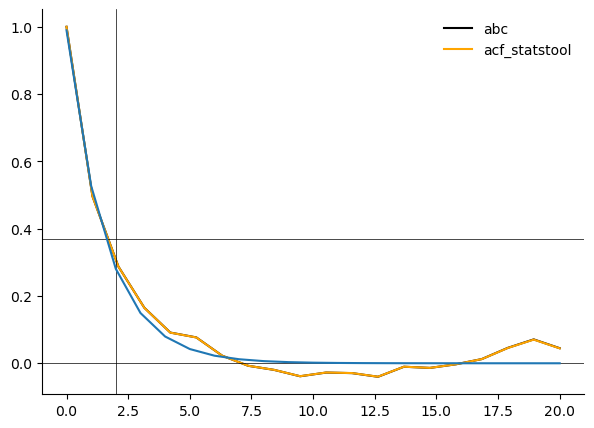

In [12]:
fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(np.linspace(0,20,20), ou_poisson_data_sumStat, c='k', label='abc')
axes.plot(np.linspace(0,20,20), ou_poisson_acf[:-1], c='orange', label='acf_statstool')
axes.axvline(x=2, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')
axes.axhline(y=0, lw=0.5, color='k')

axes.plot(np.linspace(0,20,21), func_exp_abc_like(np.linspace(0,20,21), ou_poisson_popt[0], ou_poisson_popt[1]))

axes.legend(frameon=False)

sns.despine()

In [ ]:
spike_times

In [13]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
spikeTrain_data_sumStat, spikeTrain_data_mean, spikeTrain_data_var, spikeTrain_T, spikeTrain_numTrials =  abcTau.preprocessing.extract_stats(spikeTrain, 
                                                                                                                         deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('spikeTrain_data_mean: {}, spikeTrain_data_var: {}, spikeTrain_T: {}, spikeTrain_numTrials: {}, \n spikeTrain_data_sumStat: {}'.format(spikeTrain_data_mean, 
                                                                                                                         spikeTrain_data_var, 
                                                                                                                         spikeTrain_T, 
                                                                                                                         spikeTrain_numTrials, 
                                                                                                                         spikeTrain_data_sumStat))

# Using acf func
spikeTrain_acf = acf(ou_spiketrain_binned[0], nlags=num_lags)
print('ou_poisson_acf: {}'.format(spikeTrain_acf))

# Using sttc
acf_sttc_ = acf_sttc(spike_times, num_lags, lag_shift_=binSize, sttc_dt_=25, signal_length_=T, verbose_=True)
print('acf_sttc: {}'.format(acf_sttc_))

#acf_sttc(signal_, n_lags_, lag_shift_, sttc_dt_, signal_length_, verbose_=True)

# calculate tau

# Using abc but not bayesian
ou_spiketrain_abc_popt, ou_spiketrain_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(spikeTrain_data_sumStat, binSize, maxTimeLag)
print(ou_spiketrain_abc_popt)

# Using curve_fit
ou_spiketrain_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,20,21), spikeTrain_acf, maxfev=5000)
print(ou_spiketrain_popt)

ou_spiketrain_tau_ms = ou_spiketrain_popt[1] * binSize
print(ou_spiketrain_tau_ms)

# curvefit and sttc
ou_spiketrain1_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,20,20), acf_sttc_, maxfev=5000)
print(ou_spiketrain1_popt)
ou_spiketrain1_tau_ms = ou_spiketrain1_popt[1] * binSize
print(ou_spiketrain1_tau_ms)

spikeTrain_data_mean: 2.1875, spikeTrain_data_var: 8.18234375, spikeTrain_T: 100000, spikeTrain_numTrials: 1, 
 spikeTrain_data_sumStat: [ 1.          0.49239736  0.28243248  0.16185247  0.0886162   0.07667752
  0.02351351 -0.00870613 -0.01968211 -0.04482472 -0.03298378 -0.03217217
 -0.04040398 -0.00999221 -0.0116264  -0.00663533  0.01317172  0.04112227
  0.06847242  0.04174489]
ou_poisson_acf: [ 1.          0.49215131  0.2821505   0.1616106   0.08844024  0.07648782
  0.02344463 -0.00867316 -0.01960204 -0.04462376 -0.03282076 -0.03199797
 -0.04016174 -0.00992729 -0.01154496 -0.00658597  0.01306548  0.04077162
  0.06785523  0.04134784  0.0492438 ]
shift_ms_l [ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900
 950]
STTC : 1.0
spike_1 (4375,), spike_2 (4375,)
STTC : 0.5521887614884406
spike_1 (4375,), spike_2 (4374,)
STTC : 0.3017345963151209
spike_1 (4375,), spike_2 (4373,)
STTC : 0.16394379814403334
spike_1 (4375,), spike_2 (4371,)
STTC : 0.10409873439701135
spike_

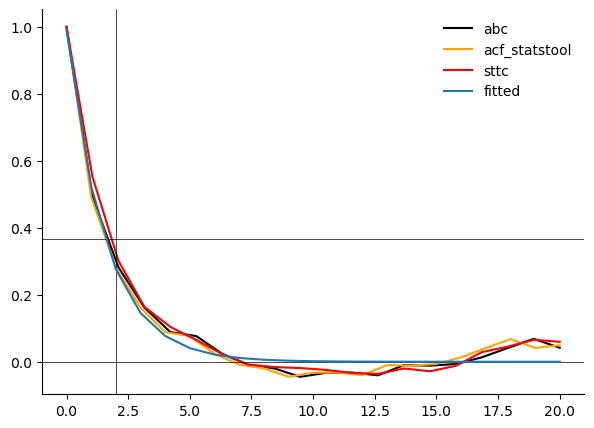

In [15]:
fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(np.linspace(0,20,20), spikeTrain_data_sumStat, c='k', label='abc')
axes.plot(np.linspace(0,20,21), spikeTrain_acf, c='orange', label='acf_statstool')
axes.plot(np.linspace(0,20,20), acf_sttc_, c='red', label='sttc')
axes.axvline(x=2, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')
axes.axhline(y=0, lw=0.5, color='k')

axes.plot(np.linspace(0,20,21), func_exp_abc_like(np.linspace(0,20,21), ou_spiketrain_popt[0], ou_spiketrain_popt[1]), label='fitted')

axes.legend(frameon=False)

sns.despine()

### Schematic of data generation

In [ ]:
# plot
fig, axes = plt.subplots(5,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,numBin-1,numBin), ou_poisson[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, scaled, shifted, rectified')

axes[2].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[2].axvline(x=50*i, color='k', lw=0.5)
axes[2].set_title('One tau OU, Poisson spike count')

axes[3].plot(spike_times, np.ones_like(spike_times), '|', markersize=10, c='salmon')  # Plot spikes as a row,
for i in range(numBinData+1):
    axes[3].axvline(x=50*i, color='k', lw=0.5)
axes[3].set_title('One tau OU, Poisson spike train')

axes[4].plot(np.linspace(0,numBinData-1,numBinData), ou_spiketrain_binned[0], lw=0.5)
axes[4].axhline(y=0, color='k', lw=0.5)
axes[4].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[4].axvline(x=i, color='k', lw=0.5)
axes[4].set_title('One tau OU, Poisson spike train, binned')

for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

#fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\' + 'data_generation_schematic.png' , bbox_inches='tight')